In [1]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
%cd .
%load_ext autoreload
%autoreload 2

## Data Exploration & Wrangling


In [ ]:
%pip install fiftyone imagehash
%pip uninstall fiftyone-db -y
%pip install fiftyone-db-ubuntu2204 --force-reinstall

In [8]:
from pathlib import Path
from functools import partial

import fiftyone as fo
import fiftyone.utils.yolo as fouy
from fiftyone import ViewField as F

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imagehash

from til_23_cv import ReIDEncoder, cos_sim, thres_strategy_A, evaluate_threshold_function

### Load Dataset


In [3]:
name = "til23plush"
dataset_dir = "data/til23plush"
splits = "train", "val", "test"

# NOTE: Uncomment to recache dataset
# fo.delete_dataset(name)

In [4]:
if name in fo.list_datasets():
    ds = fo.load_dataset(name)

    # Delete any predictions still attached
    ds.delete_sample_field("predictions", 2)
    ds.delete_evaluations()
else:
    ds = fo.Dataset(name=name, persistent=True)
    for split in splits:
        ds.add_dir(
            dataset_dir=dataset_dir,
            dataset_type=fo.types.YOLOv5Dataset,
            include_all_data=True,
            split=split,
            tags=split,
        )

    # Add Perceptual Hashes for Dupe Detection later
    # Due to multiple false positives, perceptual hash chosen is closer to cryptographic
    for sample in ds.iter_samples(progress=True, autosave=True):
        sample["phash"] = str(imagehash.dhash(Image.open(sample.filepath)))

print(ds)

Name:        til23plush
Media type:  image
Num samples: 8064
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    phash:        fiftyone.core.fields.StringField


In [5]:
# Relabel all detections to plushie
view = ds.set_field(
    "ground_truth.detections", F("detections").map(F().set_field("label", "plushie"))
)

### Dupe Detection

There were no dupes; The Object Detection this time is just that easy.

In [6]:
# Filter view to only show images where `phash` has more than 1 instance
counts = filter(lambda i: i[1] > 1, view.count_values("phash").items())
counts = [k for k, v in counts]
dupes = view.filter_field("phash", F().is_in(counts)).filter_field(
    "tags", F().contains(["train", "val"])
)

### Export YOLO Dataset for Ultralytics

Converts `til23plush` to `til23plushonly`.

In [15]:
# See: https://docs.voxel51.com/api/fiftyone.utils.yolo.html#fiftyone.utils.yolo.YOLOv5DatasetExporter
splits = "train", "val"
config = dict(
    export_dir="data/til23plushonly",
    dataset_type=fo.types.YOLOv5Dataset,
    label_field="ground_truth",
    export_media="symlink",
    include_path=False,
)

In [16]:
for split in splits:
    v = view.filter_field("tags", F().contains([split]))
    v.export(split=split, **config)

Directory 'data/til23plushonly' already exists; export will be merged with existing files
 100% |███████████████| 5664/5664 [5.1s elapsed, 0s remaining, 1.1K samples/s]       
Directory 'data/til23plushonly' already exists; export will be merged with existing files
 100% |█████████████████| 800/800 [691.1ms elapsed, 0s remaining, 1.2K samples/s]       


### Eval Object Detection

In [13]:
split = "test"
label_dir = f"runs/detect/predict/{split}/labels"

In [14]:
sview = view.filter_field("tags", F().contains([split]))
fouy.add_yolo_labels(
    sample_collection=sview,
    label_field="predictions",
    labels_path=label_dir,
    classes=["plushie"],
)
results = sview.evaluate_detections(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
)
results.print_report()

Sample field 'eval_tp' does not exist
Sample field 'eval_fp' does not exist
Sample field 'eval_fn' does not exist
Evaluating detections...
 100% |███████████████| 1600/1600 [3.7s elapsed, 0s remaining, 461.7 samples/s]      
              precision    recall  f1-score   support

     plushie       0.00      0.00      0.00       0.0

   micro avg       0.00      0.00      0.00       0.0
   macro avg       0.00      0.00      0.00       0.0
weighted avg       0.00      0.00      0.00       0.0



### Export Image Classification Dataset for Suspect Recognition

Converts `til23plush` to `til23reid`.

In [3]:
padding = 0.5, 0.0
label_field = "ground_truth"
export_dir = "data/til23reid"
splits = "train", "val"

In [4]:
for split, p in zip(splits, padding):
    ds.filter_field("tags", F().contains([split])).export(
        export_dir=f"{export_dir}/{split}",
        dataset_type=fo.types.ImageClassificationDirectoryTree,
        label_field=label_field,
        alpha=p,
        image_format=".png",
    )

Detected an image classification exporter and a label field 'ground_truth' of type <class 'fiftyone.core.labels.Detections'>. Exporting image patches...
 100% |█████████████| 12321/12321 [2.1m elapsed, 0s remaining, 95.2 samples/s]       
Detected an image classification exporter and a label field 'ground_truth' of type <class 'fiftyone.core.labels.Detections'>. Exporting image patches...
 100% |███████████████| 1699/1699 [14.6s elapsed, 0s remaining, 117.3 samples/s]      


### Eval Suspect Recognition

Used to find optimal threshold parameters.

NOTE: Suspect folder used below was handpicked from the `til23reid` dataset.

NOTE: We uses suspect images as the detection pool. But 10 > ~3 detections per test image. This might affect parameter tuning accuracy.

In [3]:
val_dir = "data/til23reid/val"
sus_dir = "data/val_suspects"
reid_path = "reid.torchscript"

In [4]:
imds = fo.Dataset.from_dir(
    dataset_dir=val_dir,
    dataset_type=fo.types.ImageClassificationDirectoryTree,
)

 100% |███████████████| 1699/1699 [554.3ms elapsed, 0s remaining, 3.1K samples/s]      


In [5]:
# Load encoder and encode suspects.
encoder = ReIDEncoder(reid_path)
embeds = {}
for pth in Path(sus_dir).glob("*.png"):
    lbl = pth.stem
    im = np.array(Image.open(pth))
    embeds[lbl] = encoder([im])[0]
embeds = dict(sorted(embeds.items()))
sus_cls = list(embeds.keys())
sus_embeds = list(embeds.values())

In [6]:
# Encode all images.
for sample in imds.iter_samples(progress=True, autosave=True):
    im = np.array(Image.open(sample.filepath))
    embeds = encoder([im])[0]
    sample["logits"] = [cos_sim(v, embeds) for v in sus_embeds]

 100% |███████████████| 1699/1699 [1.2m elapsed, 0s remaining, 23.8 samples/s]      


In [7]:
imds.delete_sample_field("predictions", 2)
for sample in imds.iter_samples(progress=True, autosave=True):
    logits = sample["logits"]
    sample["predictions"] = fo.Classification(
        label=sus_cls[np.argmax(logits)], confidence=np.max(logits), logits=logits
    )

 100% |███████████████| 1699/1699 [1.3s elapsed, 0s remaining, 1.3K samples/s]         


In [63]:
from scipy.special import softmax

# Compare PR curves for different threshold functions and tune other threshold params.
suspect_dropout = 0.5 # Adversarial case where many images have no suspect.
x_axis = np.arange(0.01, 1.0, 0.004)

evaluate = partial(
    evaluate_threshold_function,
    ds=imds,
    sus_cls=sus_cls,
    x_axis=x_axis,
    suspect_dropout=suspect_dropout,
)

naive_thres = lambda x, t: np.argmax(x) if np.max(x) > t else -1
# Can also vary `vote_thres` and 10*`sd_thres` instead of `accept_thres`.
a_thres = lambda x, t: thres_strategy_A(x, 1.0, t, 4.4)
softmax_thres = lambda x, t: np.argmax(y) if np.max(y := softmax(x/t)) > 1.4/len(x) else -1

naive_res: tuple = evaluate(func=naive_thres) # type: ignore
a_res: tuple = evaluate(func=a_thres) # type: ignore
softmax_res: tuple = evaluate(func=softmax_thres) # type: ignore

100%|██████████| 248/248 [00:12<00:00, 20.28it/s]


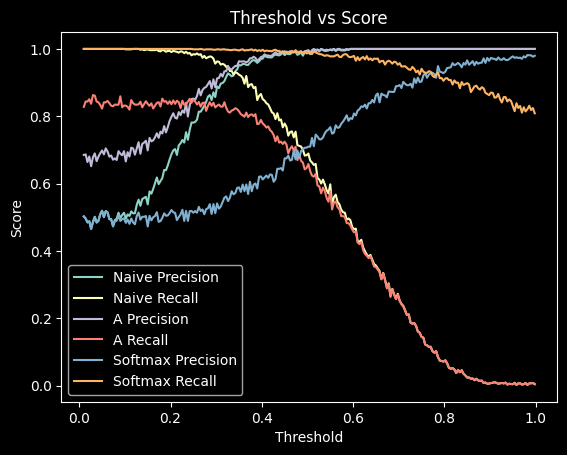

Max Naive F1 & Threshold: 0.9380637402285027 0.326
Max A F1 & Threshold: 0.8852459016393441 0.318
Max Softmax F1 & Threshold: 0.9395184967704052 0.786


In [65]:
# %matplotlib widget
# Plot comparison.
fig, ax = plt.subplots()
ax.plot(x_axis, naive_res[1], label="Naive Precision")
ax.plot(x_axis, naive_res[2], label="Naive Recall")
# ax.plot(x_axis, naive_res[0], label="Naive Accuracy")
# ax.plot(x_axis, naive_res[3], label="Naive F1")
ax.plot(x_axis, a_res[1], label="A Precision")
ax.plot(x_axis, a_res[2], label="A Recall")
# ax.plot(x_axis, a_res[0], label="A Accuracy")
# ax.plot(x_axis, a_res[3], label="A F1")
ax.plot(x_axis, softmax_res[1], label="Softmax Precision")
ax.plot(x_axis, softmax_res[2], label="Softmax Recall")
# ax.plot(x_axis, softmax_res[0], label="Softmax Accuracy")
# ax.plot(x_axis, softmax_res[3], label="Softmax F1")
ax.set_xlabel("Threshold")
ax.set_ylabel("Score")
ax.set_title("Threshold vs Score")
ax.legend()
plt.show()
print("Max Naive F1 & Threshold:", max(naive_res[3]), x_axis[np.argmax(naive_res[3])])
print("Max A F1 & Threshold:", max(a_res[3]), x_axis[np.argmax(a_res[3])])
print("Max Softmax F1 & Threshold:", max(softmax_res[3]), x_axis[np.argmax(softmax_res[3])])

In [12]:
fo.config.requirement_error_level = 1
imds.delete_evaluations()
results = imds.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
)
results.print_report()
# display(results.plot_confusion_matrix())

              precision    recall  f1-score   support

          #0       1.00      1.00      1.00       179
          #1       1.00      1.00      1.00       177
          #2       1.00      1.00      1.00       169
          #3       1.00      0.99      1.00       163
          #4       0.98      1.00      0.99       163
          #5       0.99      0.98      0.98       163
          #6       0.95      0.92      0.93       166
          #7       1.00      0.98      0.99       169
          #8       0.97      0.99      0.98       173
          #9       0.90      0.92      0.91       177

    accuracy                           0.98      1699
   macro avg       0.98      0.98      0.98      1699
weighted avg       0.98      0.98      0.98      1699



### Preview


In [ ]:
# Put whatever view or dataset below
# v = ds
# v = view
# v = dupes
# v = sview
v = imds
fo.launch_app(dataset=v)